In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from joblib import Parallel, delayed
import multiprocessing
import time
from tqdm import tqdm
from scipy.interpolate import griddata
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/')
from functions import *

In [2]:
# The total H and C mass fractions
mCO2tot=600e-6
mH2Otot=1000e-6

# set total pressure and temperature
T = 1473 # kelvin
P = 1000 # bar

# set the Oxygen fugacity to FMQ
A = 25738
B = 9
C = 0.092
log_FMQ = (-A/T+B+C*(P-1)/T)
f_O2 = 10**(log_FMQ-0)
# set to FMQ

start = time.time()
P_H2O,P_H2,P_CO2,P_CO,P_CH4,alphaG,x_CO2,x_H2O = solve_gases(T,P,f_O2,mCO2tot,mH2Otot)
print(time.time()-start)

0.00875711441040039


In [3]:
# make distributions
np.random.seed(0)
n = 10000

# Do SiO2 first
inputs = range(0,n)

# change these too
mCO2tot_r=[100e-6,50000e-6]
mH2Otot_r=[100e-6,100000e-6]
mCO2tot = np.random.uniform(low=mCO2tot_r[0], high=mCO2tot_r[1], size=n)
mH2Otot = np.random.uniform(low=mH2Otot_r[0], high=mH2Otot_r[1], size=n)

# Choose range of T and P and fO2
Tc_r = [600,2000]
Pc_r = [1e-3,100]
To_r = [600,2000]
Po_r = [100,1000]
f_O2_r = [-5,2]
X_r = [0,1]

LG = 1
Delta_f_O2 = np.random.uniform(low=f_O2_r[0], high=f_O2_r[1], size=n)
Tc = np.random.uniform(low=Tc_r[0], high=Tc_r[1], size=n)
Pc = np.random.uniform(low=Pc_r[0], high=Pc_r[1], size=n)
To = np.random.uniform(low=To_r[0], high=To_r[1], size=n)
Po = np.random.uniform(low=Po_r[0], high=Po_r[1], size=n)
X = np.random.uniform(low=X_r[0], high=X_r[1], size=n)
if LG==1:
    # log stuff
    Pc_r = [np.log10(Pc_r[0]),np.log10(Pc_r[1])]
    Pc = 10**np.random.uniform(low=Pc_r[0], high=Pc_r[1], size=n)


# little bit more to get f_O2
A = 25738
B = 9
C = 0.092
log_fO2_c = (-A/Tc+B+C*(Pc-1)/Tc)+Delta_f_O2
f_O2_c = 10**(log_fO2_c)

log_fO2_o = (-A/To+B+C*(Po-1)/To)+Delta_f_O2
f_O2_o = 10**(log_fO2_o)

In [4]:
# ocean world or just continental world
def flux_ratios_iter(T,P,f_O2,mCO2tot,mH2Otot):
    P_H2O,P_H2,P_CO2,P_CO,P_CH4,alphaG,x_CO2,x_H2O = solve_gases(T,P,f_O2,mCO2tot,mH2Otot)
    CO_CO2 = P_CO/P_CO2
    CO_CH4 = P_CO/P_CH4

    return (CO_CO2,CO_CH4)

num_cores = multiprocessing.cpu_count()
start = time.time()
resultso = Parallel(n_jobs=num_cores)(delayed(flux_ratios_iter)\
            (To[i],Po[i],f_O2_o[i],mCO2tot[i],mH2Otot[i]) for i in tqdm(inputs))
end = time.time()
print(end-start)

resultso = np.array(resultso)

100%|██████████| 10000/10000 [00:12<00:00, 825.94it/s]


12.51029896736145


In [6]:
# mix land-ocean world
def flux_ratios_iter(To,Tc,Po,Pc,f_O2_o,f_O2_c,mCO2tot,mH2Otot,X):
    P_H2O,P_H2,P_CO2,P_CO,P_CH4,alphaG,x_CO2,x_H2O = solve_gases(To,Po,f_O2_o,mCO2tot,mH2Otot)
    CO_CO2_o = P_CO/P_CO2
    CO_CH4_o = P_CO/P_CH4
    
    P_H2O,P_H2,P_CO2,P_CO,P_CH4,alphaG,x_CO2,x_H2O = solve_gases(Tc,Pc,f_O2_c,mCO2tot,mH2Otot)
    CO_CO2_c = P_CO/P_CO2
    CO_CH4_c = P_CO/P_CH4

    CO_CO2 = X*CO_CO2_c+(1-X)*CO_CO2_o
    CO_CH4 = X*CO_CH4_c+(1-X)*CO_CH4_o

    return (CO_CO2,CO_CH4)

num_cores = multiprocessing.cpu_count()
start = time.time()
resultsb = Parallel(n_jobs=num_cores)(delayed(flux_ratios_iter)\
            (To[i],Tc[i],Po[i],Pc[i],f_O2_o[i],f_O2_c[i],mCO2tot[i],mH2Otot[i],X[i]) for i in tqdm(inputs))
end = time.time()
print(end-start)

resultsb = np.array(resultsb)

100%|██████████| 10000/10000 [00:19<00:00, 515.53it/s]


19.871223211288452


In [4]:
#np.savetxt('ocean_world.txt',resultso)
resultso = np.loadtxt('ocean_world.txt')

#np.savetxt('ocean_continent_combo.txt',resultsb)
resultsb = np.loadtxt('ocean_continent_combo.txt')

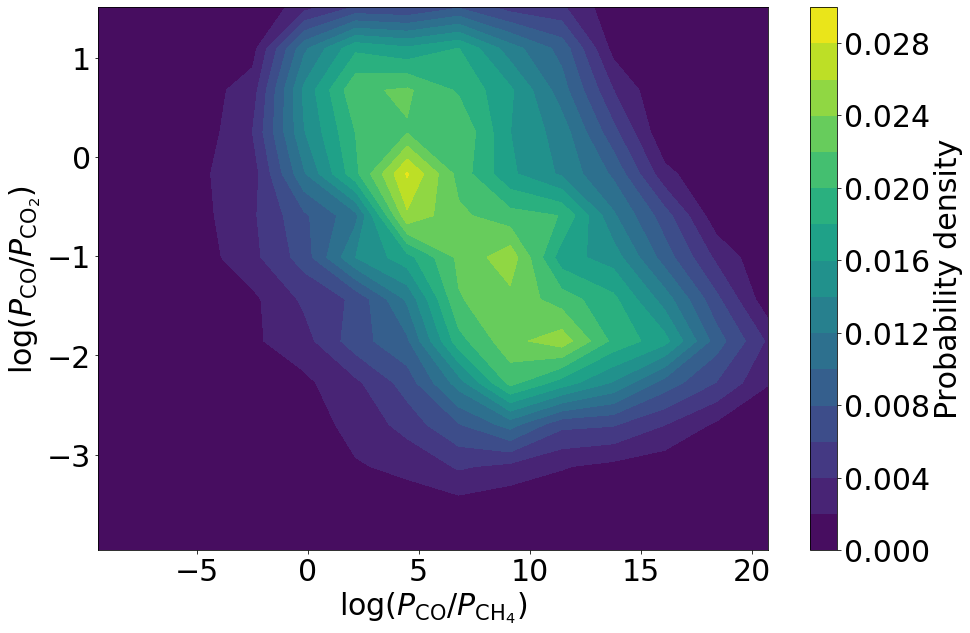

In [7]:
plt.rcParams.update({'font.size': 30})
results = resultsb

fig,ax = plt.subplots(1,1,figsize=[15,10])
xbins = np.linspace(np.log10(min(results[:,1])), np.log10(max(results[:,1])), 15)
ybins = np.linspace(np.log10(min(results[:,0])), np.log10(max(results[:,0])), 15)


counts, _, _ = np.histogram2d(np.log10(results[:,1]), np.log10(results[:,0]), bins=(xbins, ybins),normed=True)


ax.pcolormesh(xbins, ybins, counts.T)
cs = ax.contourf(counts.T,15,extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()])

ax.set_ylabel(r"$\log(P_{\mathrm{CO}}/P_{\mathrm{CO_2}})$")
ax.set_xlabel(r"$\log(P_{\mathrm{CO}}/P_{\mathrm{CH_4}})$")

cbar = plt.colorbar(cs,ax=ax)
cbar.set_label("Probability density")

#plt.savefig("monte_carlo_ocean-continental_world9999.jpg",bbox_inches='tight')
plt.show()

# Plot some dependencies

In [10]:
mCO2tot=600e-6
mH2Otot=1000e-6

# set total pressure and temperature
n = 15
m = 15
T = np.linspace(600,2000,n) # kelvin
P = 100 # bar
FMQ = np.linspace(-5,2,m)
CO_CH4 = np.zeros([n,m])

for i in range(0,len(T)):
    for j in range(0,len(FMQ)):
        # set the Oxygen fugacity to FMQ
        A = 25738
        B = 9
        C = 0.092
        log_FMQ = (-A/T[i]+B+C*(P-1)/T[i])
        f_O2 = 10**(log_FMQ+FMQ[j])
        # set to FMQ


        P_H2O,P_H2,P_CO2,P_CO,P_CH4,alphaG,x_CO2,x_H2O = solve_gases(T[i],P,f_O2,mCO2tot,mH2Otot)
        CO_CH4[i,j] = P_CO/P_CH4

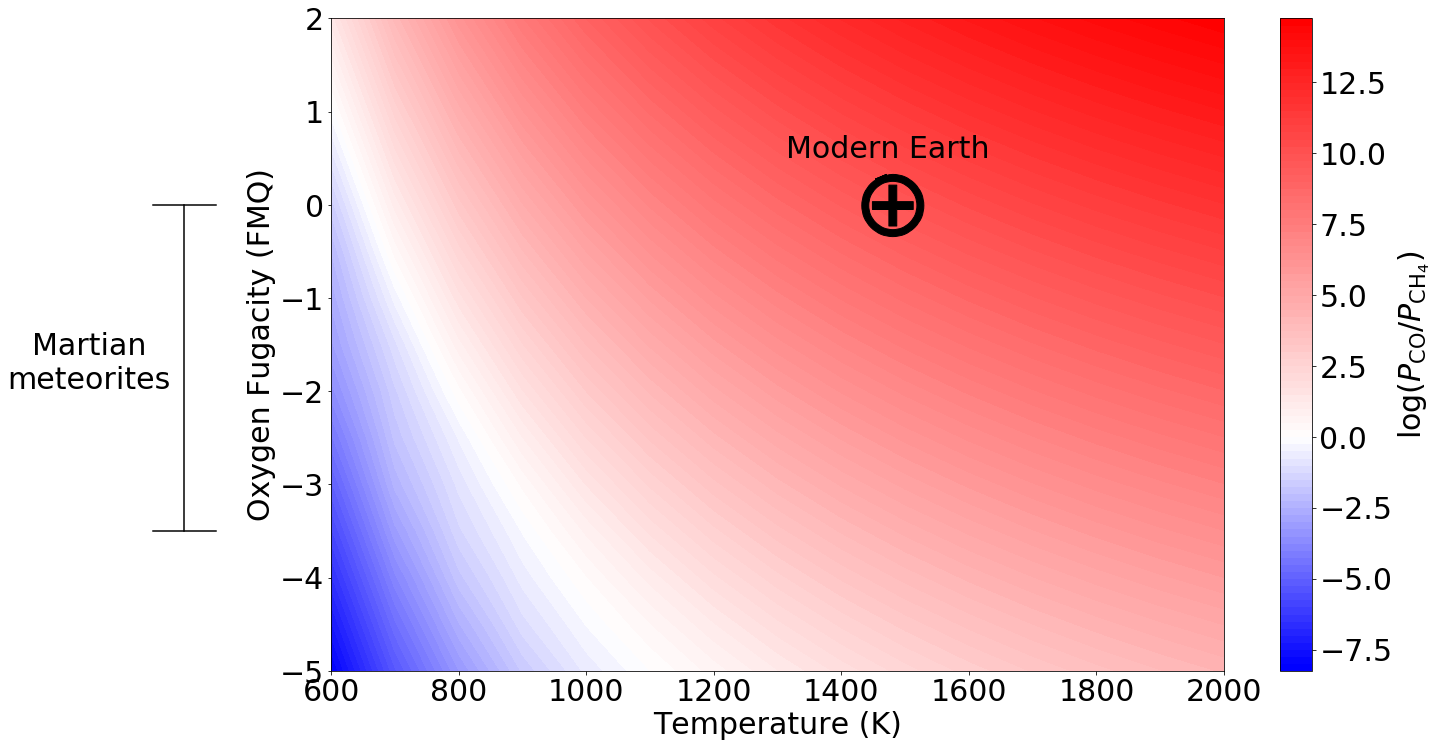

In [11]:
# plot
plt.rcParams.update({'font.size': 30})
divnorm = colors.DivergingNorm(vmin=np.min(np.log10(CO_CH4.T)), vcenter=0., vmax=np.max(np.log10(CO_CH4.T)))

fig,ax = plt.subplots(1,1,figsize = [20,12])
cs = ax.contourf(T,FMQ, np.log10(CO_CH4.T), 100,cmap ='bwr',norm=divnorm)
cbar = plt.colorbar(cs,ax=ax)  # draw colorbar
cbar.set_label(r"$\log(P_{\mathrm{CO}}/P_{\mathrm{CH_4}})$")

ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1])
ax.set_xlim(ax.get_xlim()[0],ax.get_xlim()[1])

ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Oxygen Fugacity (FMQ)')

shft = -230
ax.plot([600+shft,600+shft],[-3.5,0],clip_on=False,color='k')
ax.plot([550+shft,650+shft],[-3.5,-3.5],clip_on=False,color='k')
ax.plot([550+shft,650+shft],[0,0],clip_on=False,color='k')
ax.text(800+shft-350,-1.7,"Martian\nmeteorites",verticalalignment='center',horizontalalignment='center',color='k')

#ax.arrow(750+shft,0,-200,0,head_width=.2,head_length=40,fc='k',color='k')
#ax.text(1100+10+shft,0,"Modern Earth upper\nmantle average",verticalalignment='center',horizontalalignment='center',color='k')
ax.scatter(1473,0,marker=r'$\oplus$',s=5000, c='k',zorder=10)
ax.text(1473,0+.5,"Modern Earth",horizontalalignment='center',color='k')

#plt.savefig("test1.jpg",bbox_inches='tight')

plt.show()